In [60]:
# Imports
import os
from autoregressive_versus_teacher_forcing import *
import pickle5 as pickle # for Python 3.8
import torch.nn.functional as F
import torch
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams; rcParams["figure.figsize"] = 10, 7
import seaborn as sns; sns.set()

In [18]:
# Load a tokenizer decoder (GPT2 tokenizer)
model_paths = get_all_model_paths()
_, tokenizer_decoder = get_model_tokenizer_decoder(model_paths['snli'][1.0]['decoder_path'], 'snli')

CONFIG: {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "latent_size": 768,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torchscript": false,
  "vocab_size": 50260
}



In [19]:
# Fetch the results from the evaluation result directory and load them into a dictionary
eval_result_dir =  'evaluation-results/'
all_results = {}

for result_dir in os.listdir(eval_result_dir):
    print("Setting:", result_dir)
    all_results[result_dir]  = pickle.load(open(eval_result_dir + result_dir + '/' + 'results.pickle', 'rb'))

Setting: snli-0.0
Setting: wikipedia-0.0
Setting: wikipedia-0.5
Setting: snli-0.5
Setting: snli-1.0


In [20]:
def sentence_from_tok_ids(tok_ids_tensor, tokenizer_decoder):
    """
    Converts a tensor of token ids to a string of text.
    """
    
    text = tokenizer_decoder.decode(tok_ids_tensor.tolist())
    if '<EOS>' in text:
        text = text.split('<EOS>')[0]
    return text

def preds_batches_to_text(preds, tokenizer_decoder):
    """
    Converts list of tensor batch predictions (token_ids) to a list of text predictions. 
    """
    
    text_preds = []
    
    for batch in preds:
        for i in range(batch.shape[0]):
            s = batch[i, :]
            text_preds.append(sentence_from_tok_ids(s, tokenizer_decoder))
            
    return text_preds

In [27]:
summary_results = {}
textual_results = {}

def flatten_tensor_batch_list(tensor_batch_list):
    list_of_lists = [batch.tolist() for batch in tensor_batch_list]
    flat_list = [item for sublist in list_of_lists for item in sublist] 
    return flat_list

for setting, result in all_results.items():
    accs_tf = result['all_accs_tf']
    mean_acc_tf, std_acc_tf = accs_tf.mean().item(), accs_tf.std().item()

    accs_auto = result['all_accs_auto']
    mean_acc_auto, std_acc_auto = accs_auto.mean().item(), accs_auto.std().item()
    
    all_ce_losses_auto = result['all_ce_losses_auto']
    mean_ce_auto, std_ce_auto = all_ce_losses_auto.mean().item(), all_ce_losses_auto.std().item()
    
    all_ce_losses_tf = result['all_ce_losses_tf']
    mean_ce_tf, std_ce_tf = all_ce_losses_tf.mean().item(), all_ce_losses_tf.std().item()
    
    all_prop_ppls_auto = result['all_prop_ppls_auto']
    mean_ppl_auto, std_ppl_auto = all_prop_ppls_auto.mean().item(), all_prop_ppls_auto.std().item()
    
    all_prop_ppls_tf = result['all_prop_ppls_tf']
    mean_ppl_tf, std_ppl_tf = all_prop_ppls_tf.mean().item(), all_prop_ppls_tf.std().item()
    
    textual_preds_auto = preds_batches_to_text(result['all_preds_auto'], tokenizer_decoder)
    textual_preds_tf = preds_batches_to_text(result['all_preds_tf'], tokenizer_decoder)
    
    textual_results[setting] = {
        'text_preds_auto': textual_preds_auto,
        'text_preds_tf': textual_preds_tf
    }
    
    summary_results[setting] = {
        'mean_acc_tf':mean_acc_tf,
        'std_acc_tf':std_acc_tf,
        'all_accs_tf':accs_tf,
    
        'mean_acc_auto':mean_acc_auto,
        'std_acc_auto':std_acc_auto,
        'all_accs_auto':accs_auto,
        
        'mean_ce_auto':mean_ce_auto,
        'std_ce_auto':std_ce_auto,
        'all_ce_auto': all_ce_losses_auto,
        
        'mean_ppl_from_mean_ce_auto':np.exp(mean_ce_auto),
        'mean_ppl_from_mean_ce_tf':np.exp(mean_ce_tf),
        
        'mean_ce_tf':mean_ce_tf,
        'std_ce_tf':std_ce_tf,
        'all_ce_tf': all_ce_losses_tf,
        
        'mean_ppl_auto': mean_ppl_auto,
        'std_ppl_auto': std_ppl_auto,
        'all_ppl_auto': all_prop_ppls_auto,
        
        'mean_ppl_tf': mean_ppl_tf,
        'std_ppl_tf': std_ppl_tf,
        'all_ppl_tf': all_prop_ppls_tf,
        
        'all_labels': flatten_tensor_batch_list(result['all_labels']),
        'all_preds_auto': flatten_tensor_batch_list(result['all_preds_auto']),
        'all_preds_tf': flatten_tensor_batch_list(result['all_preds_tf']),
        
        'sentences': result['all_sentences'],
        'sentence_lengths': [len(s.split(' ')) for s in result['all_sentences']]
    }
    
df = pd.DataFrame(summary_results).transpose()
df = df[['mean_acc_tf', 'std_acc_tf', 'mean_acc_auto', 'std_acc_auto', 'mean_ce_auto', 'std_ce_auto', 'mean_ce_tf', 'std_ce_tf', 'mean_ppl_from_mean_ce_auto', 'mean_ppl_from_mean_ce_tf']]
df

,mean_acc_tf,std_acc_tf,mean_acc_auto,std_acc_auto,mean_ce_auto,std_ce_auto,mean_ce_tf,std_ce_tf,mean_ppl_from_mean_ce_auto,mean_ppl_from_mean_ce_tf
snli-0.0,0.787287,0.146689,0.63721,0.297156,5.04972,4.12351,2.0203,0.981925,155.979,7.54062
wikipedia-0.0,0.207086,0.104805,0.0231856,0.048467,9.66611,1.73113,3.4821,0.757872,15773.8,32.5278
wikipedia-0.5,0.207086,0.104805,0.0231856,0.048467,9.66611,1.73113,3.4821,0.757872,15773.8,32.5278
snli-0.5,0.787176,0.146639,0.636898,0.29694,5.04252,4.10343,2.02651,0.984661,154.86,7.58755
snli-1.0,0.787244,0.146787,0.637417,0.29692,5.03484,4.10535,2.0202,0.981247,153.676,7.53982


In [90]:
import numpy as np

sentences = pickle.load(open(SENTENCES_FILE, 'rb'))

for i in range(30):
    print('*'*50)
    print("Original sentence:")
    print(summary_results['snli-0.5']['sentences'][i])
    
    print("\n** Wikipedia (beta=0.5) reconstructions:")
    print("- Auto regressive:")
    print(textual_results['wikipedia-0.5']['text_preds_auto'][i])
    print('ACC:', summary_results['wikipedia-0.5']['all_accs_auto'][i].item())
    print('PPL:', summary_results['wikipedia-0.5']['all_ppl_auto'][i].item())
    print('CE: ', summary_results['wikipedia-0.5']['all_ce_auto'][i].item())

    print("\n- Teacher forcing:")
    print(textual_results['wikipedia-0.5']['text_preds_tf'][i])
    print('ACC:', summary_results['wikipedia-0.5']['all_accs_tf'][i].item())
    print('PPL:', summary_results['wikipedia-0.5']['all_ppl_tf'][i].item())
    print('CE: ', summary_results['wikipedia-0.5']['all_ce_tf'][i].item())
    
    print("\n\n** SNLI (beta=0.5) reconstructions:")
    print("- Auto regressive:")
    print(textual_results['snli-0.5']['text_preds_auto'][i])
    print('ACC:', summary_results['snli-0.5']['all_accs_auto'][i].item())
    print('PPL:', summary_results['snli-0.5']['all_ppl_auto'][i].item())
    print('CE :', summary_results['snli-0.5']['all_ce_auto'][i].item())
    
    print("\n- Teacher forcing:")
    print(textual_results['snli-0.5']['text_preds_tf'][i])
    print('ACC:', summary_results['snli-0.5']['all_accs_tf'][i].item())
    print('PPL:', summary_results['snli-0.5']['all_ppl_tf'][i].item())
    print('CE: ', summary_results['snli-0.5']['all_ce_tf'][i].item())
    print('*'*50)

**************************************************
Original sentence:
a man wearing a blue coat and jeans eating a hotdog.

** Wikipedia (beta=0.5) reconstructions:
- Auto regressive:
 He was wearing a carnival costume, riding a train on a cliff. 
ACC: 0.23076923191547394
PPL: 1014.28759765625
CE:  6.921941757202148

- Teacher forcing:
 B doll with a baseball mask and black and a shoe chocolate and 
ACC: 0.23076923191547394
PPL: 17.266738891601562
CE:  2.8487820625305176


** SNLI (beta=0.5) reconstructions:
- Auto regressive:
 a man wearing a blue coat and jeans eating a hotdog. 
ACC: 0.9230769276618958
PPL: 5.9389495849609375
CE : 1.7815322875976562

- Teacher forcing:
 a man wearing a blue coat and jeans eating a hotdog. 
ACC: 0.9230769276618958
PPL: 5.93895959854126
CE:  1.78153395652771
**************************************************
**************************************************
Original sentence:
a border collie is outside jumping over an obstacle.

** Wikipedia (beta=0.5

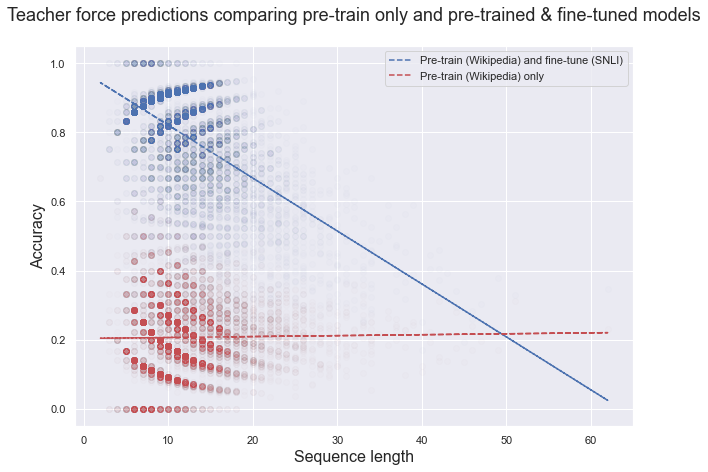

In [70]:
import matplotlib.pyplot as plt

accs = summary_results['snli-0.0']['all_accs_tf'].tolist()
lens = summary_results['snli-0.0']['sentence_lengths'][:len(accs)]
plt.scatter(lens, accs, alpha=0.01, color='b')
z = np.polyfit(lens, accs, 1)
p = np.poly1d(z)
plt.plot(lens, p(lens),"b--", label='Pre-train (Wikipedia) and fine-tune (SNLI)')

accs = summary_results['wikipedia-0.0']['all_accs_tf'].tolist()
lens = summary_results['wikipedia-0.0']['sentence_lengths'][:len(accs)]
plt.scatter(lens, accs, alpha=0.01, color='r')
z = np.polyfit(lens, accs, 1)
p = np.poly1d(z)
plt.plot(lens, p(lens),"r--", label='Pre-train (Wikipedia) only')

plt.title("Teacher force predictions comparing pre-train only and pre-trained & fine-tuned models", fontsize=18, y=1.05)
plt.xlabel("Sequence length", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.legend()
plt.show()

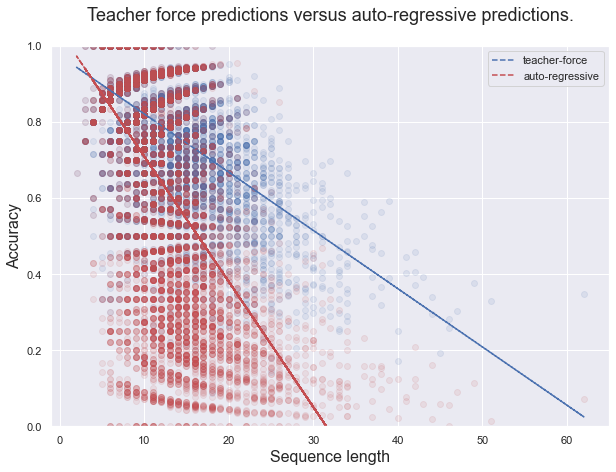

In [73]:
accs = summary_results['snli-0.0']['all_accs_tf'].tolist()
lens = summary_results['snli-0.0']['sentence_lengths'][:len(accs)]
plt.scatter(lens, accs, alpha=0.1, color='b')
z = np.polyfit(lens, accs, 1)
p = np.poly1d(z)
plt.plot(lens, p(lens),"b--", label='teacher-force')

accs = summary_results['snli-0.0']['all_accs_auto'].tolist()
lens = summary_results['snli-0.0']['sentence_lengths'][:len(accs)]
plt.scatter(lens, accs, alpha=0.1, color='r')
z = np.polyfit(lens, accs, 1)
p = np.poly1d(z)
plt.plot(lens, p(lens),"r--", label='auto-regressive')

plt.title("Teacher force predictions versus auto-regressive predictions.", fontsize=18, y=1.05)
plt.xlabel("Sequence length", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.ylim(0, 1)
    
plt.legend()
plt.show()

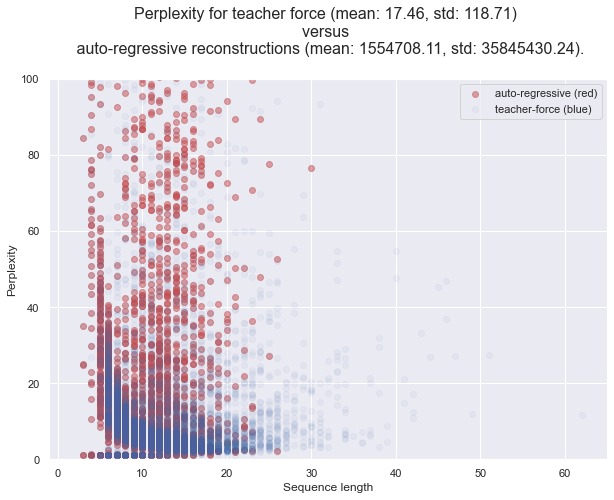

In [81]:

lens = summary_results['snli-0.0']['sentence_lengths'][:len(accs)]


ppls_auto = summary_results['snli-0.0']['all_ppl_auto'].tolist()
plt.scatter(lens, ppls, alpha=0.5, color='r', label='auto-regressive (red)')

ppls_tf = summary_results['snli-0.0']['all_ppl_tf'].tolist()
plt.scatter(lens, ppls_tf, alpha=0.05, color='b', label='teacher-force (blue)')

plt.title("Perplexity for teacher force (mean: {:.2f}, std: {:.2f}) \nversus \n auto-regressive reconstructions (mean: {:.2f}, std: {:.2f}).".format(np.mean(ppls_tf), 
                                                                                                                                np.std(ppls_tf), 
                                                                                                                                np.mean(ppls_auto),                                                                                                                        np.std(ppls_auto)), fontsize=16, y=1.05)
plt.ylim(0, 100)
plt.legend()
plt.ylabel("Perplexity", fontsize=12)
plt.xlabel("Sequence length", fontsize=12)

plt.show()

In [89]:
print("Mean perplexity auto-regressive:", summary_results['snli-0.0']['all_ppl_auto'].mean().item())
print("Mean perplexity teacher forced:", summary_results['snli-0.0']['all_ppl_tf'].mean().item())
print("Mean cross entropy auto-regressive:", summary_results['snli-0.0']['mean_ce_auto'])
print("Mean cross entropy teacher forced:", summary_results['snli-0.0']['mean_ce_tf'])

print("Perplexity from mean cross entropy auto-regressive:", np.exp(summary_results['snli-0.0']['mean_ce_auto']))
print("Perplexity from mean cross entropy teacher forced:", np.exp(summary_results['snli-0.0']['mean_ce_tf']))

Mean perplexity auto-regressive: 1554707.5
Mean perplexity teacher forced: 17.456850051879883
Mean cross entropy auto-regressive: 5.049724102020264
Mean cross entropy teacher forced: 2.0203042030334473
Perplexity from mean cross entropy auto-regressive: 155.97942414129486
Perplexity from mean cross entropy teacher forced: 7.54061846380558
